In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.cross_validation
from scipy import io
from scipy import stats
import xgboost as xgb
from sklearn import linear_model

## Import Data

In [2]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
folder='/home/jglaser2/Data/'


data=io.loadmat(folder+'hc_data_5before_5after_rnn_all.mat')


X=data['X']
y=data['Y']


In [3]:
X_sum=np.sum(np.sum(X,axis=0),axis=0)
X_sum.shape
# rmv_temp=np.where(X_sum/X.shape[1]<20)
rmv_temp=np.where(X_sum/X.shape[1]<100)
X=np.delete(X,rmv_temp,2)


#num_secs = X.shape[0]*.05


## Preprocess Data

In [4]:
X.shape

(27854, 10, 46)

In [5]:
#Normalize
X=stats.zscore(X,axis=0)
y_mean=np.mean(y,axis=0)
y_std=np.std(y,axis=0)
y=stats.zscore(y,axis=0)

In [6]:
#Put in "flat" format for XGB and linear
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
X_flat=stats.zscore(X_flat,axis=0)


**Split into training/validation/testing sets**

In [7]:
#Train/test/valid
train_prop=0.5
test_prop=0.2
valid_prop=0.2

train_size=np.int(np.round(train_prop*X.shape[0]))
test_size=np.int(np.round(test_prop*X.shape[0]))

X_train=X[:train_size-X.shape[1],:,:] #Subtract X.shape[1] so we don't have overlap in the train/test sets
y_train=y[:train_size-X.shape[1],:]

X_test=X[train_size:test_size+train_size,:,:]
y_test=y[train_size:test_size+train_size,:]

X_valid=X[test_size+train_size:,:,:]
y_valid=y[test_size+train_size:,:]


X_flat_train=X_flat[:train_size-X.shape[1],:]
X_flat_test=X_flat[train_size:test_size+train_size,:]
X_flat_valid=X_flat[test_size+train_size:,:]


In [8]:
X_flat_train.shape
y_train.shape

(13917, 2)

In [220]:
# train_prop=0.8
# valid_prop=0.1
# test_prop=0.1

# train_size=np.int(np.round(train_prop*X.shape[0]))
# valid_size=np.int(np.round(valid_prop*X.shape[0]))
# test_size=np.int(np.round(test_prop*X.shape[0]))

# X_train=X[:train_size,:,:]
# y_train=y[:train_size,:]

# X_valid=X[train_size:valid_size+train_size,:,:]
# y_valid=y[train_size:valid_size+train_size,:]

# X_test=X[valid_size+train_size:,:,:]
# y_test=y[valid_size+train_size:,:]

In [221]:
# valid_prop=0.1
# train_prop=0.8
# test_prop=0.1

# train_size=np.int(np.round(train_prop*X.shape[0]))
# valid_size=np.int(np.round(valid_prop*X.shape[0]))
# test_size=np.int(np.round(test_prop*X.shape[0]))

# X_valid=X[:valid_size,:,:]
# y_valid=y[:valid_size,:]

# X_train=X[valid_size:valid_size+train_size,:,:]
# y_train=y[valid_size:valid_size+train_size,:]

# X_test=X[valid_size+train_size:,:,:]
# y_test=y[valid_size+train_size:,:]

In [222]:
y_train.shape

(13917, 2)

In [223]:
y_test.shape

(13927, 2)

## Testing Functions

In [224]:
#Get correlations

# def get_corr(y_test,y_test_pred):

#     test_r_x=np.corrcoef(y_test[:,0],y_test_pred[:,0])[0,1]
#     test_r_y=np.corrcoef(y_test[:,1],y_test_pred[:,1])[0,1]
# #     test_r_xp=np.corrcoef(y_test[:,2],y_test_pred[:,2])[0,1]
# #     test_r_yp=np.corrcoef(y_test[:,3],y_test_pred[:,3])[0,1]
    
#     r2=[test_r_x**2, test_r_y**2]
# #     r2=[test_r_x**2, test_r_y**2, test_r_xp**2, test_r_yp**2]


#     return r2

In [9]:
def get_corr(y_test,y_test_pred):

    r2_list=[]
    for i in range(y_test.shape[1]):
        y_mean=np.mean(y_test[:,i])
        r2=1-np.sum((y_test_pred[:,i]-y_test[:,i])**2)/np.sum((y_test[:,i]-y_mean)**2)
        r2_list.append(r2)
    return r2_list

## Define Decoders

**Import packages**

In [10]:
#Import everything for keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed, Flatten, SimpleRNN, GRU, BatchNormalization
from keras.regularizers import l2, activity_l2, l1
# from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping


Using Theano backend.
Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


**GRU**

In [11]:
def GRU_model(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,units=400,dropout=0,num_epochs=10,verbose=0):
    model=Sequential()
    model.add(GRU(units,input_shape=(X.shape[1],X.shape[2]),dropout_W=dropout,dropout_U=dropout))
#     model.add(GRU(units,input_shape=(X.shape[1],X.shape[2])))
    if dropout!=0:
        model.add(Dropout(dropout))
    model.add(Dense(2,init='uniform'))
    model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
    model.fit(X_train,y_train,nb_epoch=num_epochs,verbose=verbose)
    y_test_pred=model.predict(X_test)
    r2=get_corr(y_test=y_test,y_test_pred=y_test_pred)
    return r2,y_test_pred

**LSTM**

In [239]:
def LSTM_model(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,units=400,dropout=0,num_epochs=10,verbose=0):
    model=Sequential()
    model.add(LSTM(units,input_shape=(X.shape[1],X.shape[2])))
    if dropout!=0:
        model.add(Dropout(dropout))
    model.add(Dense(2,init='uniform'))
    model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
    model.fit(X_train,y_train,nb_epoch=num_epochs,verbose=verbose)
    y_test_pred=model.predict(X_test)
    r2=get_corr(y_test=y_test,y_test_pred=y_test_pred)
    return r2

**Simple RNN**

In [297]:
def SimpleRNN_model(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,units=400,dropout=0,num_epochs=10,verbose=0):
    model=Sequential()
    model.add(SimpleRNN(units,input_shape=(X.shape[1],X.shape[2]),dropout_W=dropout,dropout_U=dropout))
    if dropout!=0:
        model.add(Dropout(dropout))
    model.add(Dense(2,init='uniform'))
    model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
    model.fit(X_train,y_train,nb_epoch=num_epochs,verbose=verbose)
    y_test_pred=model.predict(X_test)
    r2=get_corr(y_test=y_test,y_test_pred=y_test_pred)
    return r2

**XGBoost**

In [298]:
def xgb_model(X_train=X_flat_train,y_train=y_train,X_test=X_flat_test,y_test=y_test,max_depth=3,lam=1,subsample=1,num_round=300):

 
    #Set parameters
    param = {'objective': "reg:linear", #for linear output
        'eval_metric': "logloss", #loglikelihood loss
        'max_depth': max_depth, #this is the only parameter we have set, it's one of the way or regularizing
        'seed': 2925, #for reproducibility
        'silent': 1,
            'lambda': lam,
            'subsample': subsample}
    param['nthread'] = -1 #with -1 it will use all available threads

    dtest = xgb.DMatrix(X_test)

    r2=np.zeros(2)
    for y_idx in range(2):

        dtrain = xgb.DMatrix(X_train, label=y_train[:,y_idx])
        bst = xgb.train(param, dtrain, num_round)
        # make prediction
        y_test_pred = bst.predict(dtest)
        r2[y_idx]=test_r_x=(np.corrcoef(y_test[:,y_idx],y_test_pred)[0,1])**2
        
    return r2


In [12]:
def lin_reg_model(X_flat_test=X_flat_test, y_test=y_test):
    
    regr = linear_model.LinearRegression()
    regr.fit(X_flat_train, y_train) #Train    
    y_test_pred=regr.predict(X_flat_test)
    r2=get_corr(y_test=y_test,y_test_pred=y_test_pred)
    return r2,y_test_pred

In [300]:
def wiener_cascade_model(X_flat_test=X_flat_test, y_test=y_test):
    #Fits linear, and then nonlinear on top of that
    
    regr = linear_model.LinearRegression()
    regr.fit(X_flat_train, y_train) #Train
    y_train_pred0=regr.predict(X_flat_train)
    y_test_pred0=regr.predict(X_flat_test)

    #x velocity
    X_x_train=np.zeros((y_train_pred0.shape[0],2))
    X_x_train[:,0]=y_train_pred0[:,0]
    X_x_train[:,1]=y_train_pred0[:,0]**2

    X_x_test=np.zeros((y_test_pred0.shape[0],2))
    X_x_test[:,0]=y_test_pred0[:,0]
    X_x_test[:,1]=y_test_pred0[:,0]**2

    regr_x = linear_model.LinearRegression()
    regr_x.fit(X_x_train, y_train[:,0]) #Train

    y_test_pred_x=regr_x.predict(X_x_test)


    #y velocity
    X_y_train=np.zeros((y_train_pred0.shape[0],2))
    X_y_train[:,0]=y_train_pred0[:,1]
    X_y_train[:,1]=y_train_pred0[:,1]**2

    X_y_test=np.zeros((y_test_pred0.shape[0],2))
    X_y_test[:,0]=y_test_pred0[:,1]
    X_y_test[:,1]=y_test_pred0[:,1]**2

    regr_y = linear_model.LinearRegression()
    regr_y.fit(X_y_train, y_train[:,1]) #Train

    y_test_pred_y=regr_y.predict(X_y_test)

    #Concatenate x and y predictions int
    y_test_pred=np.concatenate((np.expand_dims(y_test_pred_x,axis=1),np.expand_dims(y_test_pred_y,axis=1)),axis=1)

    r2=get_corr(y_test=y_test,y_test_pred=y_test_pred)
    return r2

In [324]:
def wiener_cascade_model_v2(num_epochs=30, verbose=0, X_flat_test=X_flat_test, y_test=y_test):
    #Wiener cascade using NN (essentially allows iterations back and forth)
    from keras.models import Model
    from keras.layers.core import Lambda
    from keras.layers import Input, merge

    #Model
    inputs = Input(shape=(X_flat.shape[1],), name='main_input')
    linear=Dense(1,activation='linear')(inputs)
    squared=Lambda(lambda x: x ** 2)(linear)
#     cubed=Lambda(lambda x: x ** 3)(linear)
    # merge_layer=merge([linear,squared,cubed],mode='concat')
    merge_layer=merge([linear,squared],mode='concat')
#     norm_merge=BatchNormalization(merge_layer)
    output=Dense(1,activation='linear')(merge_layer)
    model = Model(input=inputs, output=output)
    model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])

    model.fit(X_flat_train,y_train[:,0],nb_epoch=num_epochs,verbose=verbose)
    y_test_pred_x=model.predict(X_flat_test)

    model.fit(X_flat_train,y_train[:,1],nb_epoch=num_epochs,verbose=verbose)
    y_test_pred_y=model.predict(X_flat_test)

    y_test_pred=np.concatenate((y_test_pred_x,y_test_pred_y),axis=1)
    r2=get_corr(y_test=y_test,y_test_pred=y_test_pred)
    return r2


**Fit Model**

In [310]:
# r2_simpleRNN=SimpleRNN_model(verbose=1, num_epochs=20, units=100, dropout=0.25, X_test=X_valid, y_test=y_valid)
r2_simpleRNN=SimpleRNN_model(verbose=1, num_epochs=20, units=100, dropout=0.25)
print(np.mean(r2_simpleRNN))
r2_simpleRNN

#20, .25, 50 gave .321
#10, .25, 100 gave .302
#20, .25, 100 gave .338
#30, .25, 100 gave .328
#10, .25, 200 gave .270



Epoch 1/20
13917/13917 [==============================] - 3s - loss: 0.5953 - acc: 0.7240     
Epoch 2/20
13917/13917 [==============================] - 3s - loss: 0.5191 - acc: 0.7552     
Epoch 3/20
13917/13917 [==============================] - 3s - loss: 0.5071 - acc: 0.7559     
Epoch 4/20
13917/13917 [==============================] - 3s - loss: 0.4900 - acc: 0.7634     
Epoch 5/20
13917/13917 [==============================] - 3s - loss: 0.4867 - acc: 0.7652     
Epoch 6/20
13917/13917 [==============================] - 3s - loss: 0.4739 - acc: 0.7679     
Epoch 7/20
13917/13917 [==============================] - 3s - loss: 0.4715 - acc: 0.7729     
Epoch 8/20
13917/13917 [==============================] - 3s - loss: 0.4642 - acc: 0.7746     
Epoch 9/20
13917/13917 [==============================] - 3s - loss: 0.4536 - acc: 0.7732     
Epoch 10/20
13917/13917 [==============================] - 3s - loss: 0.4562 - acc: 0.7742     
Epoch 11/20
13917/13917 [========================

[0.43931087398972746, 0.52657160959542082]

In [13]:
# r2_GRU=GRU_model(verbose=1,dropout=0.5,num_epochs=20,units=200, X_test=X_valid, y_test=y_valid)
[r2_GRU,y_test_pred_rnn]=GRU_model(verbose=1,dropout=0.5,num_epochs=10,units=200, X_test=X_test, y_test=y_test)
print(np.mean(r2_GRU))
r2_GRU

#0.25,5,100 gave .311
#0.25,10,50 gave .283
#0.25,10,100 gave .312
#0.25,20,100 gave .248
#0.5,10,100 gave .332
#0.5,10,200 gave .369
#0.5,20,200 gave .287
#0.5,10,400 gave .329



Epoch 1/10
13917/13917 [==============================] - 8s - loss: 0.6803 - acc: 0.6962     
Epoch 2/10
13917/13917 [==============================] - 8s - loss: 0.6093 - acc: 0.7199     
Epoch 3/10
13917/13917 [==============================] - 8s - loss: 0.5562 - acc: 0.7397     
Epoch 4/10
13917/13917 [==============================] - 8s - loss: 0.5188 - acc: 0.7565     
Epoch 5/10
13917/13917 [==============================] - 8s - loss: 0.4864 - acc: 0.7700     
Epoch 6/10
13917/13917 [==============================] - 8s - loss: 0.4626 - acc: 0.7793     
Epoch 7/10
13917/13917 [==============================] - 8s - loss: 0.4484 - acc: 0.7860     
Epoch 8/10
13917/13917 [==============================] - 8s - loss: 0.4320 - acc: 0.7901     
Epoch 9/10
13917/13917 [==============================] - 8s - loss: 0.4299 - acc: 0.7927     
Epoch 10/10
13917/13917 [==============================] - 8s - loss: 0.4183 - acc: 0.7936     
0.489854757303


[0.40135440032098479, 0.5783551142846739]

In [27]:
r2_LSTM=LSTM_model()
print(np.mean(r2_LSTM))
r2_LSTM

0.820542884674


[0.84402145456453104, 0.79706431478400486]

In [14]:
# r2_lin_reg=lin_reg_model(X_flat_test=X_flat_valid, y_test=y_valid)
[r2_lin_reg,y_test_pred_lin]=lin_reg_model(X_flat_test=X_flat_test, y_test=y_test)
print(np.mean(r2_lin_reg))
r2_lin_reg

0.284003825391


[0.26712926478005306, 0.30087838600217143]

In [307]:
r2_wiener_casc=wiener_cascade_model()
print(np.mean(r2_wiener_casc))
r2_wiener_casc

0.280059685857


[0.24286439475592503, 0.31725497695900495]

In [323]:
r2_wiener_casc_v2=wiener_cascade_model_v2(num_epochs=20,X_flat_test=X_flat_valid, y_test=y_valid)
# r2_wiener_casc_v2=wiener_cascade_model_v2(num_epochs=20,X_flat_test=X_flat_test, y_test=y_test)
print(np.mean(r2_wiener_casc_v2))
r2_wiener_casc_v2

0.0327482317949


[0.028409057047185438, 0.037087406542553825]

In [309]:
# r2_xgb=xgb_model(X_test=X_flat_valid, y_test=y_valid,num_round=200,max_depth=3,lam=1,subsample=1)
r2_xgb=xgb_model(X_test=X_flat_test, y_test=y_test,num_round=200)
print(np.mean(r2_xgb))
r2_xgb
#.227 w/ numround=200, other defaults (for validation)

0.438796848206


array([ 0.39189858,  0.48569512])

**Plot**

In [15]:
fig_folder='/home/jglaser2/GitProj/BMI/Figs/'

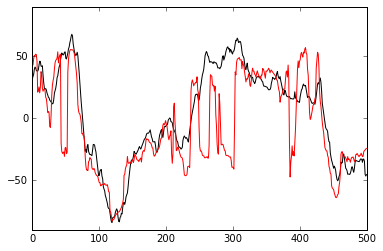

In [30]:
fig_x_rnn=plt.figure()
plt.plot(y_test[3000:3500,0]*y_std[0],color='k')
plt.plot(y_test_pred_rnn[3000:3500,0]*y_std[0],color='r')
plt.ylim([-90,90])
fig_x_rnn.savefig(fig_folder+'hc_x_rnn.eps')

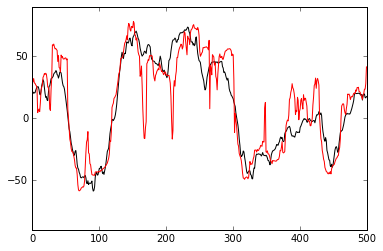

In [31]:
fig_y_rnn=plt.figure()
plt.plot(y_test[3000:3500,1]*y_std[1],color='k')
plt.plot(y_test_pred_rnn[3000:3500,1]*y_std[1],color='r')
plt.ylim([-90,90])
fig_y_rnn.savefig(fig_folder+'hc_y_rnn.eps')

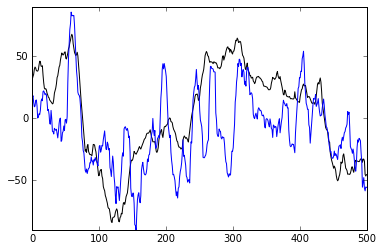

In [32]:
fig_x_lin=plt.figure()
plt.plot(y_test[3000:3500,0]*y_std[0],color='k')
plt.plot(y_test_pred_lin[3000:3500,0]*y_std[0],color='b')
plt.ylim([-90,90])
fig_x_lin.savefig(fig_folder+'hc_x_lin.eps')

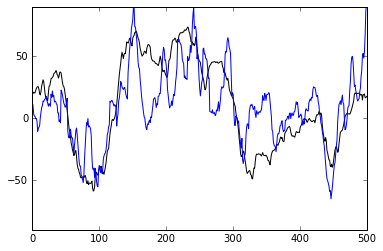

In [33]:
fig_y_lin=plt.figure()
plt.plot(y_test[3000:3500,1]*y_std[1],color='k')
plt.plot(y_test_pred_lin[3000:3500,1]*y_std[1],color='b')
plt.ylim([-90,90])
fig_y_lin.savefig(fig_folder+'hc_y_lin.eps')

**Save**

In [30]:
#Combine for saving
# r2_all=[]
# r2_all.append({'SimpleRNN': r2_simpleRNN, 'XGB': r2_xgb})

# r2_all_means=[]


# r2_all[0]['XGB']

In [33]:
import pickle

# Saving the objects:
with open(folder+'mih_214.pickle', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([r2_simpleRNN, r2_GRU, r2_LSTM, r2_xgb, r2_lin_reg], f)



In [32]:
#Loading commands
# with open(folder+'mih_115.pickle') as f:  # Python 3: open(..., 'rb')
#     r2_simpleRNN, r2_GRU, r2_LSTM, r2_xgb, r2_lin_reg = pickle.load(f)